In [1]:
import os
import sys
sys.path.append("../pyFiles/")
sys.path.append("../")

import evaluateSegAlgo as ev
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

    
import logging

#fmt = 'logging.Formatter(''%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)

np.set_printoptions(precision=2)

In [2]:
import pickle

file = open('../sessionFiles.pickle', 'rb')
allSessions = pickle.load(file)
file.close()

sessionDict = allSessions[0]
sessionDict.keys()

dict_keys(['subID', 'trialInfo', 'expConfig', 'rawExpUnity', 'rawExpGaze', 'processedExp', 'rawCalibUnity', 'rawCalibGaze', 'processedCalib', 'analysisParameters', 'calibrationQuality'])

In [3]:
import copy
sessionIn = copy.deepcopy(sessionDict)

In [4]:
def calcTrialLevelCalibInfo(sessionIn):

    '''
    Input: Session dictionary
    Output:  Session dictionary with new column sessionDict['trialInfo']['targetType']
    '''

    gbProcessedCalib_trial = sessionIn['processedCalib'].groupby(['trialNumber'])

    targetTypes = []
    gridSize_height = []
    gridSize_width = []
    targeLocalPos_az = []
    targeLocalPos_el = []


    gbProcessedCalib_trial = sessionIn['processedCalib'].groupby(['trialNumber'])

    for trialRowIdx, trMetaData in sessionIn['trialInfo'].iterrows():

        targetType = []
        height = []
        width = []

        # This dataframe contains the per-frame processed data associated with this trial

        if ( trMetaData['trialType'][0] == 'CalibrationAssessment'):

            procDF = gbProcessedCalib_trial.get_group(int(trMetaData['trialNumber']))

            if( sum(procDF['isHeadFixed'] == False) ==  len(procDF) ):

                targetType = 'VOR'
                height = np.nan
                width = np.nan

            elif( sum(procDF['isHeadFixed'] == True) == len(procDF) ):

                height = np.float64(procDF['elevationHeight'].drop_duplicates())
                width = np.float64(procDF['azimuthWidth'].drop_duplicates())

                # Count the number of target positions within the local space (head-centered space)
                if( len(procDF['targeLocalPos'].drop_duplicates()) == 1 ):
                    # Only one target, so it's a fixation trial
                    targetType = 'fixation'

                    target_az = np.round(np.float64(procDF[('targetInHead_az')].drop_duplicates()),1)
                    target_el = np.round(np.float64(procDF[('targetInHead_el')].drop_duplicates()),1)

                else:
                    # multiple targets, so it's a saccade trial
                    targetType = 'fixation+saccade'

                    target_az = np.nan
                    target_el = np.nan

        else:

            # The trial has both head fixed and world fixed targets.  
            # We did not plan for that, so let's label it as "unknown."

            targetType = 'n/a'
            height = np.nan
            width = np.nan
            target_az = np.nan
            target_el = np.nan        


    #         print('Trial number: {tNum}, type: {tType}'.format(tNum = int(trMetaData['trialNumber']),
    #                                                            tType = targetType))

        targetTypes.append(targetType)
        gridSize_height.append(height)
        gridSize_width.append(width)
        targeLocalPos_az.append(target_az)
        targeLocalPos_el.append(target_el)


    sessionIn['trialInfo']['targetType'] = targetTypes
    sessionIn['trialInfo']['gridSize','heightDegs'] = gridSize_height
    sessionIn['trialInfo']['gridSize','widthDegs'] = gridSize_width
    sessionIn['trialInfo']['fixTargetSpherical','az'] = targeLocalPos_az
    sessionIn['trialInfo']['fixTargetSpherical','el'] = targeLocalPos_el

    sessionIn['trialInfo']['fixTargetSpherical','az'] = sessionIn['trialInfo']['fixTargetSpherical','az'].round(2)
    sessionIn['trialInfo']['fixTargetSpherical','el'] = sessionIn['trialInfo']['fixTargetSpherical','el'].round(2)

    logger.info('Added sessionDict[\'trialInfo\'][\'targetType\']')
    logger.info('Added sessionDict[\'trialInfo\'][\'gridSize\']')
    logger.info('Added sessionDict[\'trialInfo\'][\'fixTargetSpherical\']')

    return sessionIn


# calcGazeToTargetFixError

In [5]:

def calcSphericalCoordinates(sessionDictIn,columnName,newColumnName,sessionDictKey='processedExp', flipY = False):

    dataDict = sessionDictIn[sessionDictKey]
    dataDict[(newColumnName,'az')] = np.rad2deg(np.arctan2(dataDict[(columnName,'x')],dataDict[(columnName,'z')]))
    dataDict[(newColumnName,'el')] = np.rad2deg(np.arctan2(dataDict[(columnName,'y')],dataDict[(columnName,'z')]))
    
    if flipY:
        dataDict[(newColumnName,'el')] = -    dataDict[(newColumnName,'el')]

    sessionDictIn[sessionDictKey] = dataDict
    
    logger.info('Added sessionDict[\'{0}\'][\'{1}\',\'az\']'.format(sessionDictKey, newColumnName))
    logger.info('Added sessionDict[\'{0}\'][\'{1}\',\'el\']'.format(sessionDictKey,newColumnName))
    
    return sessionDictIn


In [6]:
def calcGazeToTargetFixError(sessionDictIn,gazeLabelIn,targetLabelIn,columnOutLabel ):


    # For each frame of the dataframe, calculate the distance between gaze and the target
    sessionDictIn['processedCalib'][(columnOutLabel,'az')] = sessionDictIn['processedCalib'].apply(lambda row: row[(gazeLabelIn,'az')] -  row[(targetLabelIn,'az')],axis=1 )
    sessionDictIn['processedCalib'][(columnOutLabel,'el')] = sessionDictIn['processedCalib'].apply(lambda row: row[(gazeLabelIn,'el')] -  row[(targetLabelIn,'el')],axis=1 )
    sessionDictIn['processedCalib'][(columnOutLabel,'euclidean')] = np.sqrt(sessionDictIn['processedCalib'][(columnOutLabel,'az')]**2 + sessionDictIn['processedCalib'][(columnOutLabel,'el')]**2)

    # Group by trial, so that we can average within trial
    gbProcessedCalib_trial = sessionDictIn['processedCalib'].groupby(['trialNumber'])

    meanError = gbProcessedCalib_trial.agg(np.nanmean)[columnOutLabel]    
    meanOutLabel = 'mean' + columnOutLabel[0].capitalize() + columnOutLabel[1:]

    def adjToTrialInfo(newVals, sessionDictIn):

        calibAssRowidx = sessionDictIn['trialInfo'][sessionDictIn['trialInfo']['trialType'] == 'CalibrationAssessment'].index
        newVec = np.zeros(len(sessionDictIn['trialInfo']))
        newVec[:] = np.nan
        newVec[calibAssRowidx] = newVals
        return newVec


    sessionDictIn['trialInfo'][(meanOutLabel,'az')] = adjToTrialInfo(meanError['az'], sessionDictIn)
    sessionDictIn['trialInfo'][(meanOutLabel,'el')] = adjToTrialInfo(meanError['el'], sessionDictIn)
    sessionDictIn['trialInfo'][(meanOutLabel,'euclidean')] = np.sqrt(sessionDictIn['trialInfo'][(meanOutLabel,'az')]**2 + sessionDictIn['trialInfo'][(meanOutLabel,'el')]**2)

    stdError = gbProcessedCalib_trial.agg(np.nanstd)[columnOutLabel]    
    stdOutLabel = 'std' + columnOutLabel[0].capitalize() + columnOutLabel[1:]
    sessionDictIn['trialInfo'][(stdOutLabel,'az')] = adjToTrialInfo(stdError['az'], sessionDictIn)
    sessionDictIn['trialInfo'][(stdOutLabel,'az')] = adjToTrialInfo(stdError['el'], sessionDictIn)


    eucStdDev = np.sqrt( stdError['az'].values**2 + stdError['el'].values**2)
    sessionDictIn['trialInfo'][(stdOutLabel,'euclidean')] = adjToTrialInfo(eucStdDev, sessionDictIn)

    logger.info('Added sessionDict[\'trialInfo\'][(\'{0}\',\'az\']'.format(meanOutLabel))
    logger.info('Added sessionDict[\'trialInfo\'][(\'{0}\',\'el\']'.format(meanOutLabel))
    logger.info('Added sessionDict[\'trialInfo\'][(\'{0}\',\'euclidean\']'.format(meanOutLabel))

    logger.info('Added sessionDict[\'trialInfo\'][(\'{0}\',\'az\']'.format(stdOutLabel))
    logger.info('Added sessionDict[\'trialInfo\'][(\'{0}\',\'el\']'.format(stdOutLabel))
    logger.info('Added sessionDict[\'trialInfo\'][(\'{0}\',\'euclidean\']'.format(stdOutLabel))

    return sessionDictIn



In [7]:
sessionDictIn = sessionIn

sessionIn = calcTrialLevelCalibInfo(sessionIn);
sessionDictIn = ev.calcSphericalCoordinates(sessionDictIn,'targetPos','targetWorldSpherical', sessionDictKey = 'processedCalib')
sessionDictIn = ev.calcSphericalCoordinates(sessionDictIn,'targeLocalPos','targetLocalSpherical', sessionDictKey = 'processedCalib')

sessionDictIn = ev.calcSphericalCoordinates(sessionDictIn,'gaze-normal0','gaze0Spherical', sessionDictKey = 'processedCalib',flipY=False)
sessionDictIn = ev.calcSphericalCoordinates(sessionDictIn,'gaze-normal1','gaze1Spherical', sessionDictKey = 'processedCalib',flipY=False)
sessionDictIn = ev.calcSphericalCoordinates(sessionDictIn,'gaze_normal2','gaze2Spherical', sessionDictKey = 'processedCalib',flipY=False)

sessionDictIn = calcGazeToTargetFixError(sessionDictIn,'gaze0Spherical','targetLocalSpherical','fixError_eye0' )
sessionDictIn = calcGazeToTargetFixError(sessionDictIn,'gaze1Spherical','targetLocalSpherical','fixError_eye1')
sessionDictIn = calcGazeToTargetFixError(sessionDictIn,'gaze2Spherical','targetLocalSpherical','fixError_eye2')


INFO___main__-calcTrialLevelCalibInfo(): - Added sessionDict['trialInfo']['targetType']
INFO___main__-calcTrialLevelCalibInfo(): - Added sessionDict['trialInfo']['gridSize']
INFO___main__-calcTrialLevelCalibInfo(): - Added sessionDict['trialInfo']['fixTargetSpherical']
INFO_evaluateSegAlgo-calcSphericalCoordinates(): - Added sessionDict['processedCalib']['targetWorldSpherical','az']
INFO_evaluateSegAlgo-calcSphericalCoordinates(): - Added sessionDict['processedCalib']['targetWorldSpherical','el']
INFO_evaluateSegAlgo-calcSphericalCoordinates(): - Added sessionDict['processedCalib']['targetLocalSpherical','az']
INFO_evaluateSegAlgo-calcSphericalCoordinates(): - Added sessionDict['processedCalib']['targetLocalSpherical','el']
INFO_evaluateSegAlgo-calcSphericalCoordinates(): - Added sessionDict['processedCalib']['gaze0Spherical','az']
INFO_evaluateSegAlgo-calcSphericalCoordinates(): - Added sessionDict['processedCalib']['gaze0Spherical','el']
INFO_evaluateSegAlgo-calcSphericalCoordinates(

In [8]:
def calcAverageGazeDirPerTrial(sessionDictIn):


    def adjToTrialInfo(newVals, sessionDictIn):

        calibAssRowidx = sessionDictIn['trialInfo'][sessionDictIn['trialInfo']['trialType'] == 'CalibrationAssessment'].index
        newVec = np.zeros(len(sessionDictIn['trialInfo']))
        newVec[:] = np.nan
        newVec[calibAssRowidx] = newVals
        return newVec

    gbProcessedCalib_trial = sessionDictIn['processedCalib'].groupby(['trialNumber'])

    newVals = gbProcessedCalib_trial.agg([np.nanmean])[('gaze0Spherical','az','nanmean')].values
    sessionDictIn['trialInfo'][('meanGaze0_Spherical','az')] =  adjToTrialInfo(newVals, sessionDictIn)

    newVals = gbProcessedCalib_trial.agg([np.nanmean])[('gaze0Spherical','el','nanmean')].values
    sessionDictIn['trialInfo'][('meanGaze0_Spherical','el')] =  adjToTrialInfo(newVals, sessionDictIn)

    newVals = gbProcessedCalib_trial.agg([np.nanmean])[('gaze1Spherical','az','nanmean')].values
    sessionDictIn['trialInfo'][('meanGaze1_Spherical','az')] =  adjToTrialInfo(newVals, sessionDictIn)

    newVals = gbProcessedCalib_trial.agg([np.nanmean])[('gaze1Spherical','el','nanmean')].values
    sessionDictIn['trialInfo'][('meanGaze1_Spherical','el')] =  adjToTrialInfo(newVals, sessionDictIn)

    newVals = gbProcessedCalib_trial.agg([np.nanmean])[('gaze2Spherical','el','nanmean')].values
    sessionDictIn['trialInfo'][('meanGaze2_Spherical','el')] =  adjToTrialInfo(newVals, sessionDictIn)


    return sessionDictIn

In [9]:
sessionDictIn = calcAverageGazeDirPerTrial(sessionDictIn)

In [10]:
sessionDictIn = ev.calcFixationStatistics(sessionDictIn, confidenceThresh=False)

INFO_evaluateSegAlgo-calcFixationStatistics(): - Added sessionDict['fixAssessmentData']


<IPython.core.display.Javascript object>


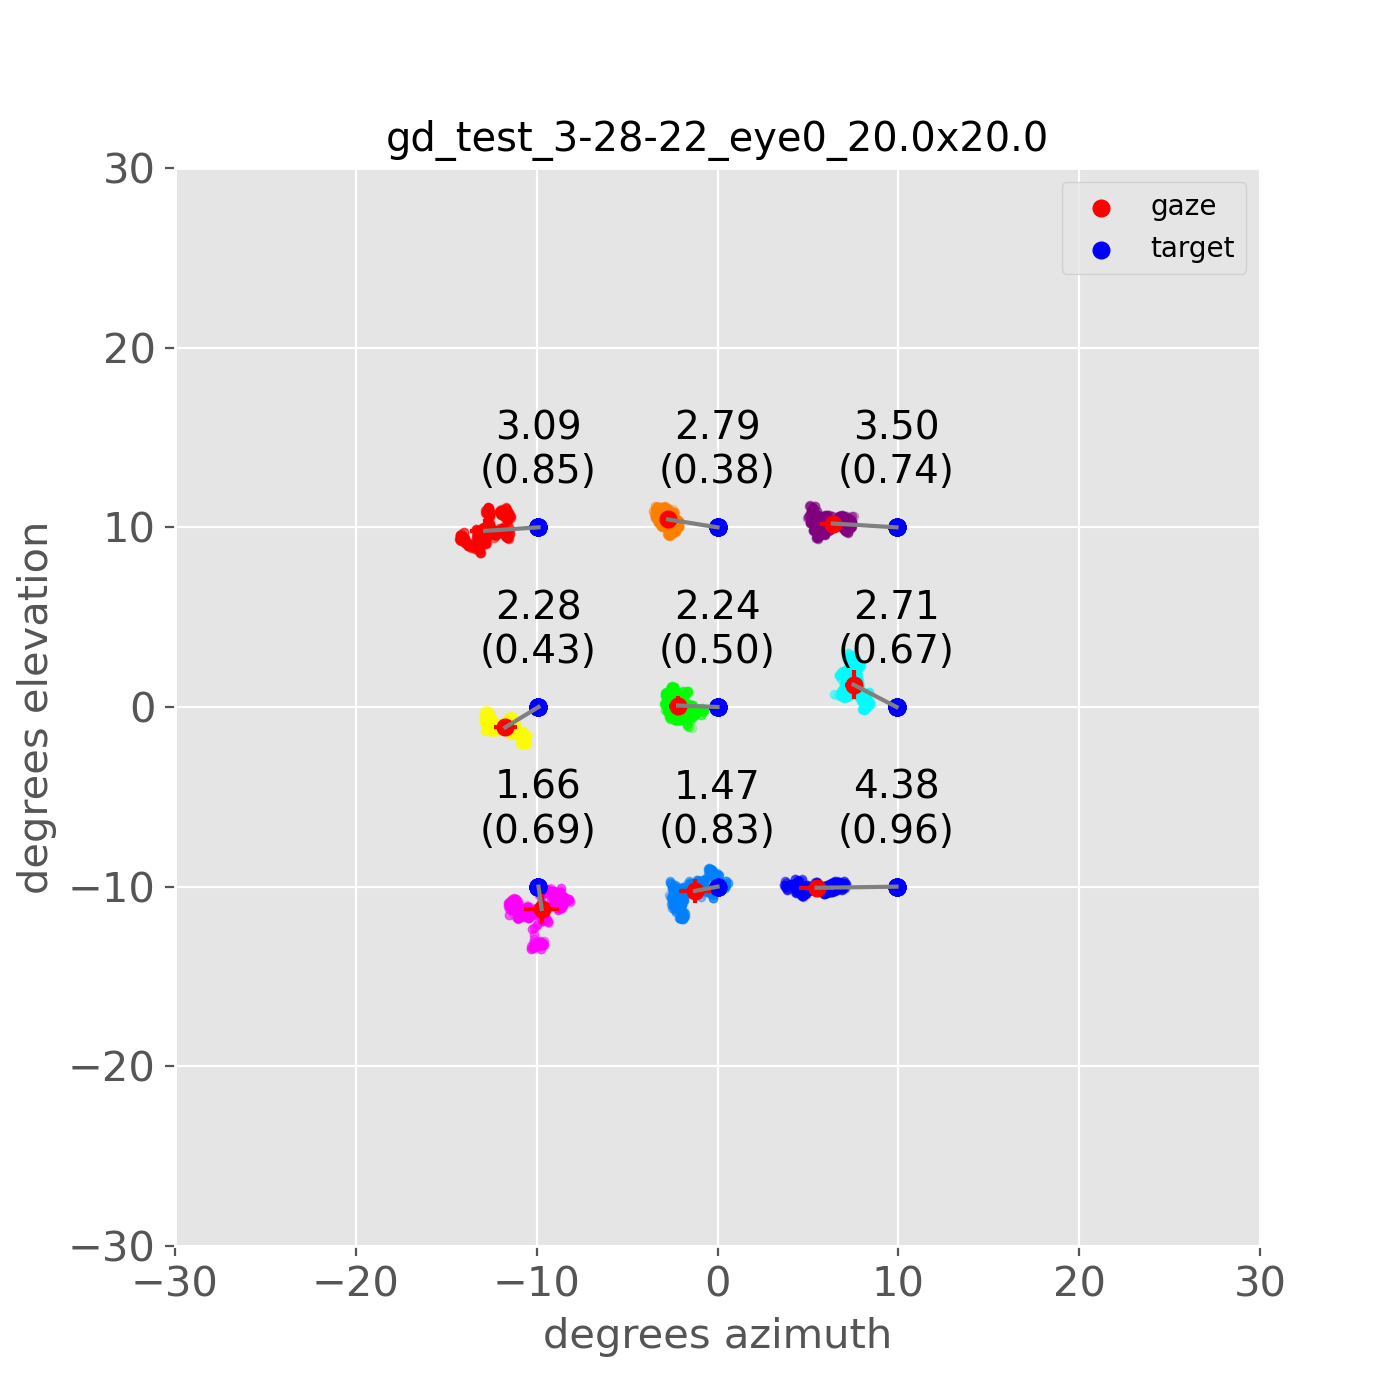

FileNotFoundError: [Errno 2] No such file or directory: 'figout/gd_test_3-28-22/'

In [11]:
ev.plotFixAssessment(sessionDictIn, saveDir = 'figout/'+ sessionDict['subID'] +"/")